<table style="text-align:center; width:100%;">
    
    <colgroup>
       <col span="1" style="width: 15%;">
       <col span="1" style="width: 50%;">
       <col span="1" style="width: 15%;">
    </colgroup>
    
    <tbody>
        <tr>
            <td><img src="../figures/milky_way_dcos.png"></td>
            <td>
                <span style="font-size:50px;">Detection Rates</span><br>
                <span style="font-size:20px;"><i>Part of the notebook series for Wagg et al. 2021</i></span><br><br>
                <p style="text-align:center; font-size:15px;">This notebook demonstrates how to reproduce the plot that examine the detection rates of Galactic DCOs in Wagg et al. (2021). The plot shows the detection rate for the 20 model variations. In order to make these plots you'll need the data, which can be found <a href="https://zenodo.org/record/4699713">here</a> on Zenodo.</p>
            </td>
            <td><img src="../figures/milky_way_dcos.png"></td>
        </tr>
    </tbody>
</table>

In [45]:
import numpy as np
import astropy.units as u
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
import seaborn as sns
import scipy
import legwork

import sys
sys.path.append("../../simulation/src/")
from variations import variations

In [46]:
%config InlineBackend.figure_format = 'retina'
plt.rc('font', family='serif')
fs = 20

params = {'legend.fontsize': fs,
         'axes.labelsize': fs,
         'xtick.labelsize':0.7*fs,
         'ytick.labelsize':0.7*fs}
plt.rcParams.update(params)
plt.rcParams['pdf.fonttype'] = 42

In [47]:
dco_colours = {"BHBH": plt.get_cmap("plasma")(0.2),
               "BHNS": plt.get_cmap("plasma")(0.5),
               "NSNS": plt.get_cmap("plasma")(0.8)}

dco_types = ["BHBH", "BHNS", "NSNS"]
data_path = "../../simulation/data/"
sim_folder = data_path + "simulation/"

detections_4yr = np.load(data_path + "detections_4yr.npy")
detections_10yr = np.load(data_path + "detections_10yr.npy")

# Define plotting function

In [34]:
def plot_variations(dco_type, variations, detections,
                    dotsize=200, capwidth=0.15,
                    xlabel="Model Variation", ylabel="LISA Detections",
                    yscale="log", fig=None, ax=None, show=True, limit=(1e0, 2e2)):
    if fig is None or ax is None:
        fig, ax = plt.subplots(1, figsize=(15, 5))
    
    # work out mean and standard deviations
    means = np.mean(detections, axis=2)[dco_types.index(dco_type)]
    errors = [scipy.stats.poisson(means).ppf(0.5 - (0.9545 / 2)),
              scipy.stats.poisson(means).ppf(0.5 - (0.6827 / 2)),
              scipy.stats.poisson(means).ppf(0.5 + (0.6827 / 2)),
              scipy.stats.poisson(means).ppf(0.5 + (0.9545 / 2))]
    
    # plot the means as points
    xticks = np.arange(len(variations)).astype(int)
    colours = np.array([variations[v]["colour"] for v in range(len(variations))], dtype="object")
    
    DONT_IGNORE_US = list(set(xticks).difference(set([17, 19])))
    
    ax.scatter(xticks[DONT_IGNORE_US], means[DONT_IGNORE_US], s=dotsize, c=colours[DONT_IGNORE_US], zorder=5)
    
    for v in range(len(variations)):
        if v in DONT_IGNORE_US:
            for width, style, indices in [(4, "-", [1, 2]), (2, "dotted", [0, 3])]:

                for index in indices:
                    # plot line up to error (adjust width and style)
                    ax.plot([xticks[v], xticks[v]], [means[v], max(errors[index][v], limit[0])],
                            color=colours[v], linewidth=width, linestyle=style)

                    if errors[index][v] < limit[0]:
                        ax.annotate("", xy=(xticks[v], limit[0]), xytext=(xticks[v], limit[0] * 1.01),
                                    arrowprops=dict(arrowstyle="->", linewidth=width, color=colours[v]), zorder=10)
                    else:
                        # plot caps on top of error bars
                        ax.plot([xticks[v] - capwidth, xticks[v] + capwidth],
                                [errors[index][v], errors[index][v]],
                                color=colours[v], linewidth=width, linestyle=style)

    ax.set_xticks(xticks)
    ax.set_xticklabels([variations[v]["short"] for v in range(len(variations))])
    
    ax.set_xlim(xticks[0] - 0.5, xticks[-1] + 0.5)
    
    ax.set_yscale(yscale)
    
    xlims = ax.get_xlim()
    
    if xlabel is not None:
        ax.set_xlabel(xlabel, fontsize=fs)
        
    if ylabel is not None:
        ax.set_ylabel(ylabel, fontsize=fs)

    ax.tick_params(axis="both", which="major", labelsize=fs, length=10)
    ax.tick_params(axis="both", which="minor", labelsize=fs, length=5)

    ax.annotate(dco_type, xy=(1 - 0.015, 0.04), xycoords="axes fraction", fontsize=fs, ha="right",
                bbox=dict(boxstyle="round", fc="white", ec="none", pad=0.0))

    ax.grid(axis="y", which="major", lw=1.5, linestyle="--")
    ax.grid(axis="y", which="minor", lw=0.3)
    
    offset = 0.3
    for lower, upper, color, label, lc, lfs in [(1, 5, "#FF9739", "Mass Transfer", "#9B5A07", fs), (6, 10, "#FFE300", "Common-Envelope", "#C3A900", fs),
                                       (11, 17, "#089CA3", "Supernovae", "#08684E", fs), (18, 19, "#7030A0", "Stellar\nWinds", "#002060", 0.7*fs)]:
        ax.axvspan(lower - offset, upper + offset, 0.88, 0.98, color="white", linewidth=0, zorder=10)
        ax.axvspan(lower - offset, upper + offset, 0.88, 0.98, color=color, alpha=0.63, linewidth=0, zorder=11)
        ax.annotate(label, xy=(((upper - lower) / 2 + 0.5 + lower) / 20, 0.93), xycoords="axes fraction", ha="center", va="center", color=lc, fontsize=lfs, fontname="Avenir", zorder=12)
    
    ax.set_ylim(limit)
    
    if show:
        plt.show()
    return fig, ax

# Detection rate plot (Figure 3)

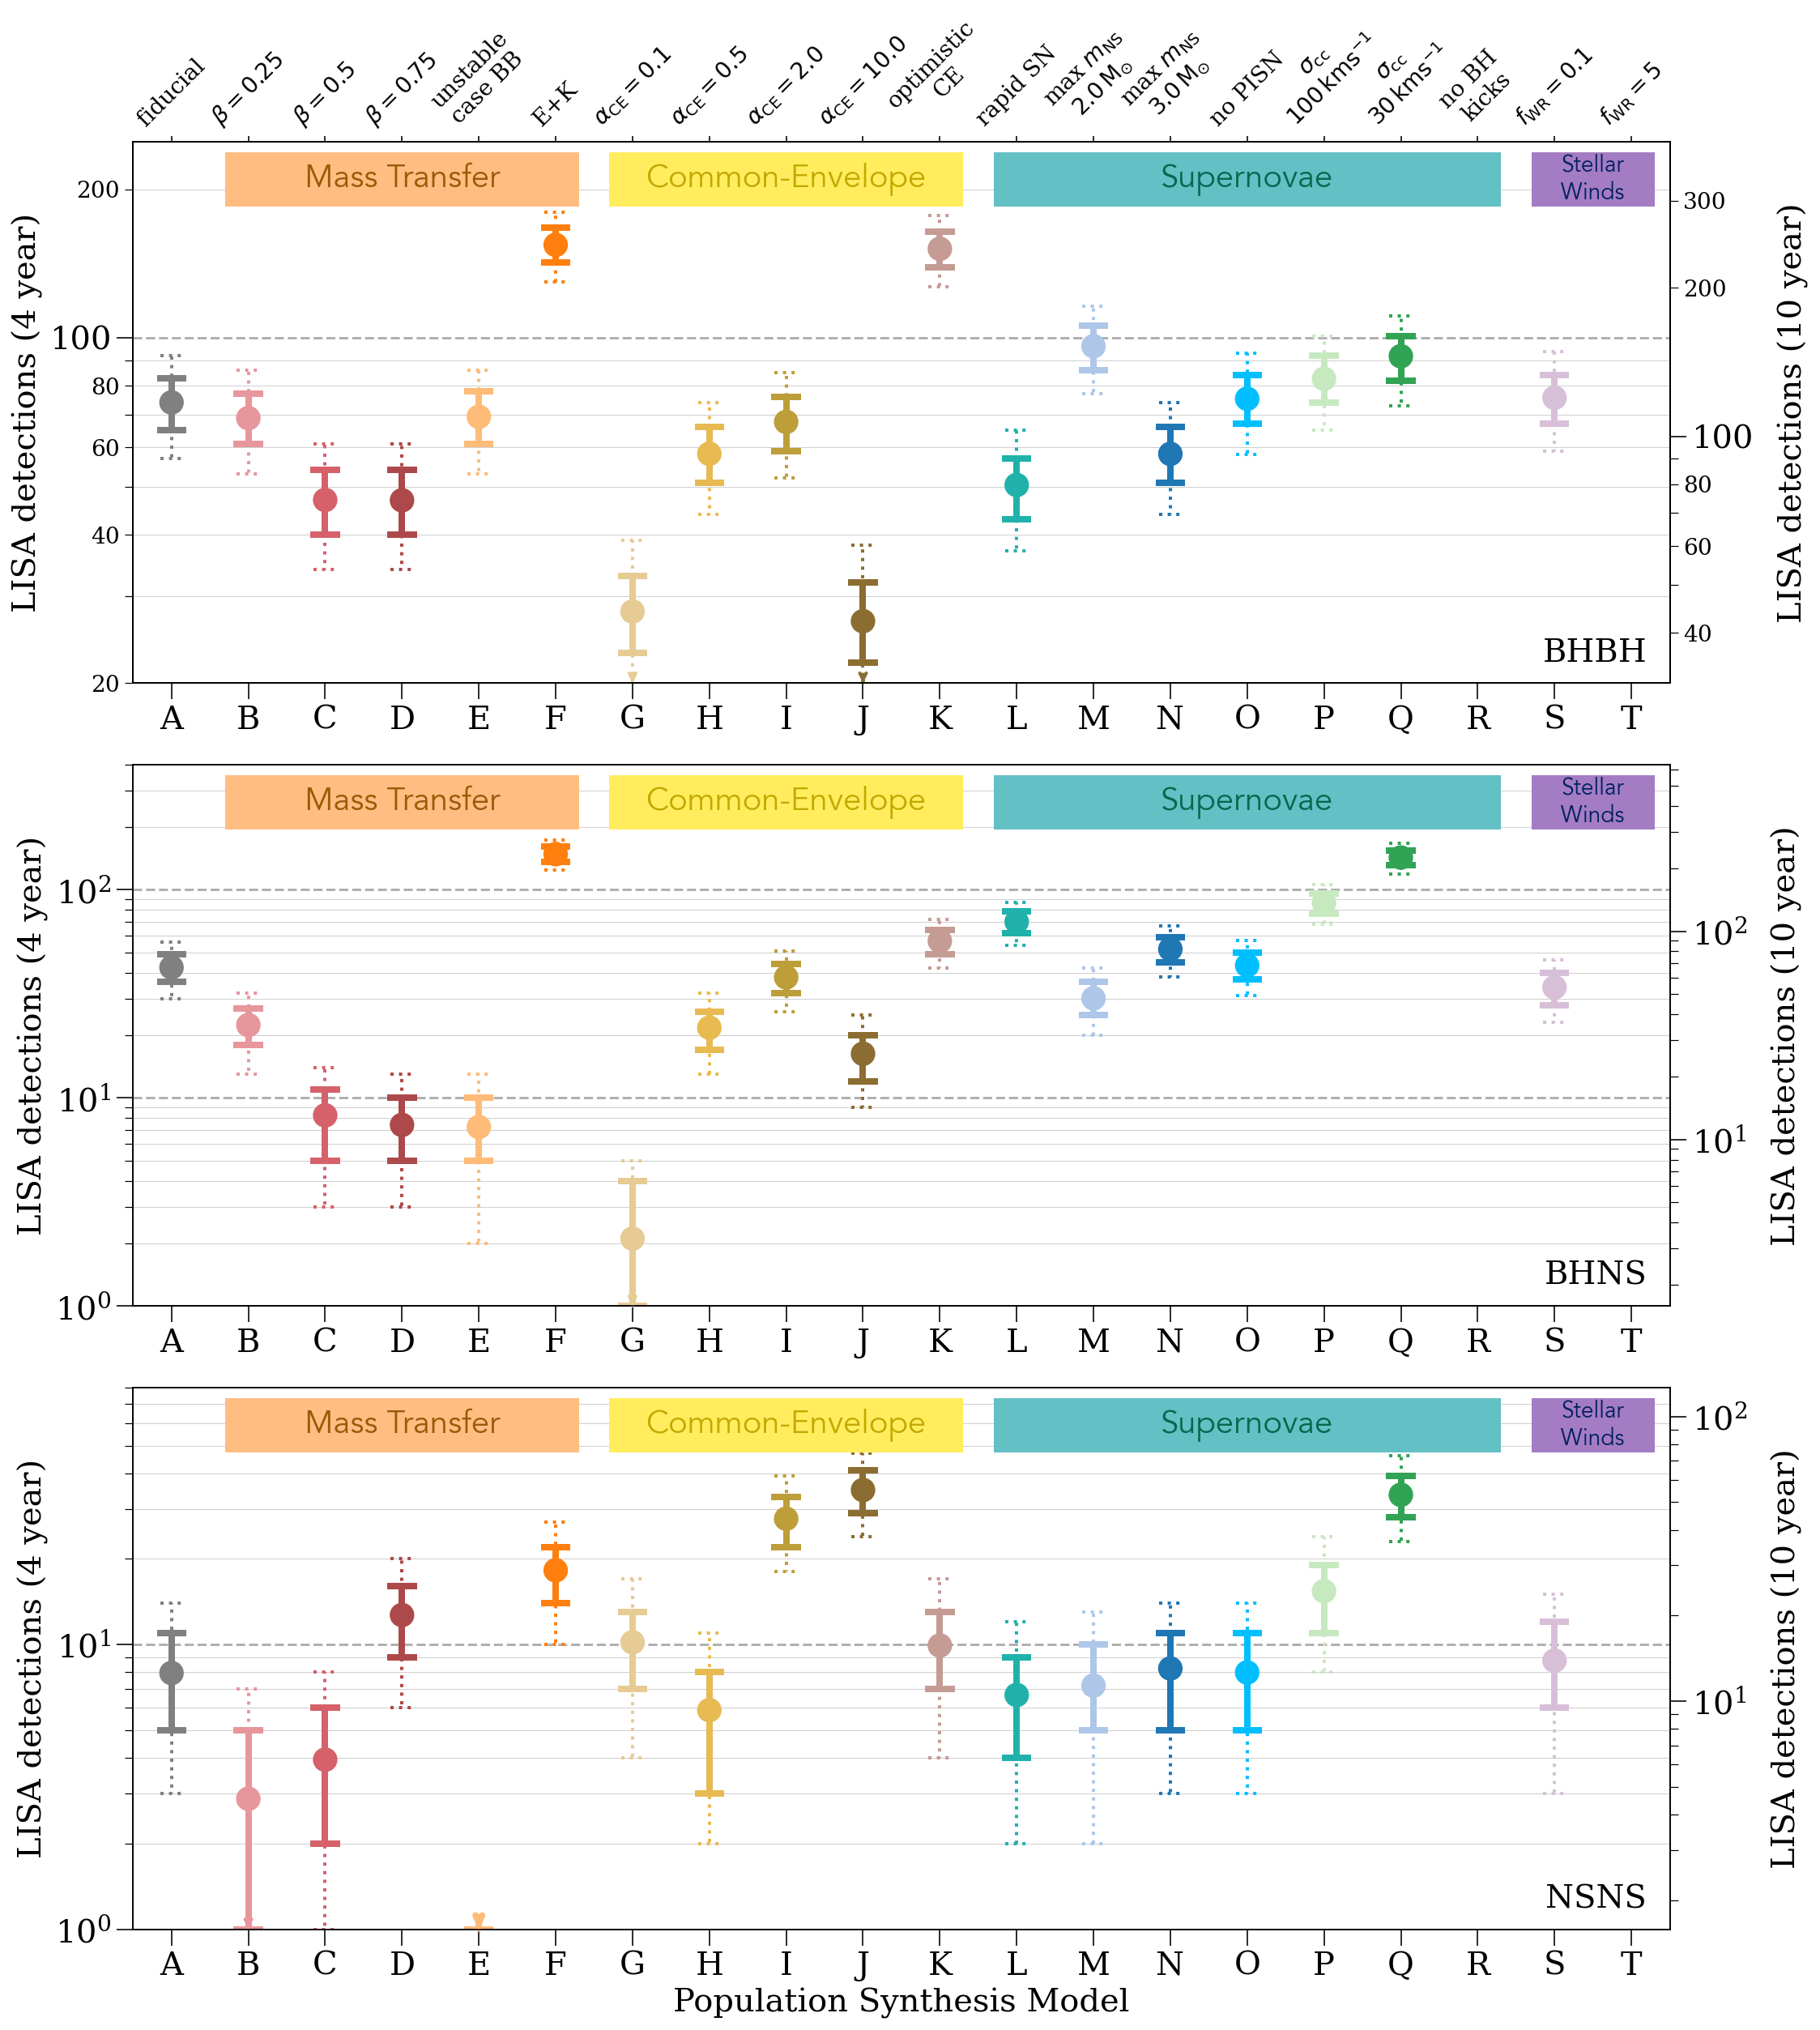

In [36]:
fig, axes = plt.subplots(3, figsize=(17, 20.3))
fig.subplots_adjust(hspace=0.15)

limits = {
    "BHBH": (2e1, 2.5e2),
    "BHNS": (1e0, 4e2),
    "NSNS": (1e0, 8e1)
}

for ax, dco_type in zip(axes, dco_types):
    plot_variations(dco_type, variations, detections_4yr,
                    xlabel=None, ylabel="LISA detections (4 year)",
                    fig=fig, ax=ax, show=False, yscale="log", limit=limits[dco_type])
    
    right_ax = ax.twinx()
    right_ax.set_ylim(tuple(np.array(ax.get_ylim()) * np.sqrt(10 / 4)))
    right_ax.set_yscale("log")
    right_ax.set_ylabel("LISA detections (10 year)", labelpad=15)
    right_ax.tick_params(axis="both", which="major", labelsize=fs, length=10)
    right_ax.tick_params(axis="both", which="minor", labelsize=fs, length=5)
    
    if dco_type == "BHBH":
        for axis, ticks, labels in zip([ax, right_ax],
                        [[20, 30, 40, 50, 60, 70, 80, 90, 200],
                         [40, 50, 60, 70, 80, 90, 200, 300]],
                        [["20", "", "40", "", "60", "", "80", "", "200"],
                         ["40", "", "60", "", "80", "", "200", "300"]]):
            axis.yaxis.set_major_formatter(ScalarFormatter())
            axis.yaxis.set_minor_formatter(ScalarFormatter())
            axis.set_yticks([100])
            axis.set_yticks(ticks, minor=True)
            axis.set_yticklabels(labels, minor=True)
            axis.tick_params(axis="y", which="minor", labelsize=0.7*fs)
    
top_ax = axes[0].twiny()
top_ax.set_xticks(axes[0].get_xticks())
top_ax.set_xlim(axes[0].get_xlim())
top_ax.set_xticklabels([variations[v]["med"] for v in range(len(variations))], rotation=45, fontsize=0.7*fs)

axes[-1].set_xlabel("Population Synthesis Model", fontsize=fs)

plt.savefig("../figures/fig3_dco_detections.pdf", format="pdf", bbox_inches="tight")
    
plt.show()

In [32]:
def plot_relative_variations(dco_type, variations, detections,
                             dotsize=50, xlabel=None, ylabel=r"$\mathcal{R}_{\rm variation} / \mathcal{R}_{\rm fiducial}$",
                             yscale="log", fig=None, ax=None, show=True, limit=(1e-2, 1e2)):
    if fig is None or ax is None:
        fig, ax = plt.subplots(1, figsize=(15, 5))
    
    # work out mean and standard deviations
    means = np.mean(detections, axis=2)[dco_types.index(dco_type)]
    
    one_sig = [scipy.stats.poisson(means).ppf(0.5 - (0.6827 / 2)),
               scipy.stats.poisson(means).ppf(0.5 + (0.6827 / 2))] / means[0]
    
    two_sig = [scipy.stats.poisson(means).ppf(0.5 - (0.9545 / 2)),
               scipy.stats.poisson(means).ppf(0.5 + (0.9545 / 2))] / means[0]
    
    means /= means[0]
    
    # plot the means as points
    xticks = np.arange(len(variations)).astype(int)
    colours = np.array([variations[v]["colour"] for v in range(len(variations))], dtype="object")
    
    DONT_IGNORE_US = list(set(xticks).difference(set([17, 19])))
    
    ax.fill_between(xticks[DONT_IGNORE_US], one_sig[0][DONT_IGNORE_US], one_sig[1][DONT_IGNORE_US], color=dco_colours[dco_type], zorder=4, lw=2, alpha=0.3)
#     ax.fill_between(xticks[DONT_IGNORE_US], two_sig[0][DONT_IGNORE_US], two_sig[1][DONT_IGNORE_US], color=dco_colours[dco_type], zorder=4, lw=2, alpha=0.1)
    
    ax.plot(xticks[DONT_IGNORE_US], means[DONT_IGNORE_US], color=dco_colours[dco_type], zorder=4, lw=2)
    ax.scatter(xticks[DONT_IGNORE_US], means[DONT_IGNORE_US], s=dotsize, color=dco_colours[dco_type], zorder=5)

    ax.set_xticks(xticks)
    ax.set_xticklabels([variations[v]["short"] for v in range(len(variations))])
    
    ax.set_xlim(xticks[0] - 0.5, xticks[-1] + 0.5)
    
    ax.set_yscale(yscale)
    
    xlims = ax.get_xlim()
    
    if xlabel is not None:
        ax.set_xlabel(xlabel, fontsize=fs)
        
    if ylabel is not None:
        ax.set_ylabel(ylabel, fontsize=fs)

    ax.tick_params(axis="both", which="major", labelsize=fs, length=10)
    ax.tick_params(axis="both", which="minor", labelsize=fs, length=5)

    ax.grid(axis="y", which="major", lw=1.5, linestyle="--")
    ax.grid(axis="y", which="minor", lw=0.3)
    
    offset = 0.3
    for lower, upper, color, label, lc, lfs in [(1, 5, "#FF9739", "Mass Transfer", "#9B5A07", fs), (6, 10, "#FFE300", "Common-Envelope", "#C3A900", fs),
                                                (11, 17, "#089CA3", "Supernovae", "#08684E", fs), (18, 19, "#7030A0", "Stellar\nWinds", "#002060", 0.7*fs)]:
        ax.axvspan(lower - offset, upper + offset, 0.88, 0.98, color="white", linewidth=0, zorder=10)
        ax.axvspan(lower - offset, upper + offset, 0.88, 0.98, color=color, alpha=0.63, linewidth=0, zorder=11)
        ax.annotate(label, xy=(((upper - lower) / 2 + 0.5 + lower) / 20, 0.93), xycoords="axes fraction", ha="center", va="center", color=lc, fontsize=lfs, fontname="Avenir", zorder=12)
    
    ax.set_ylim(limit)
    
    if show:
        plt.show()
    return fig, ax

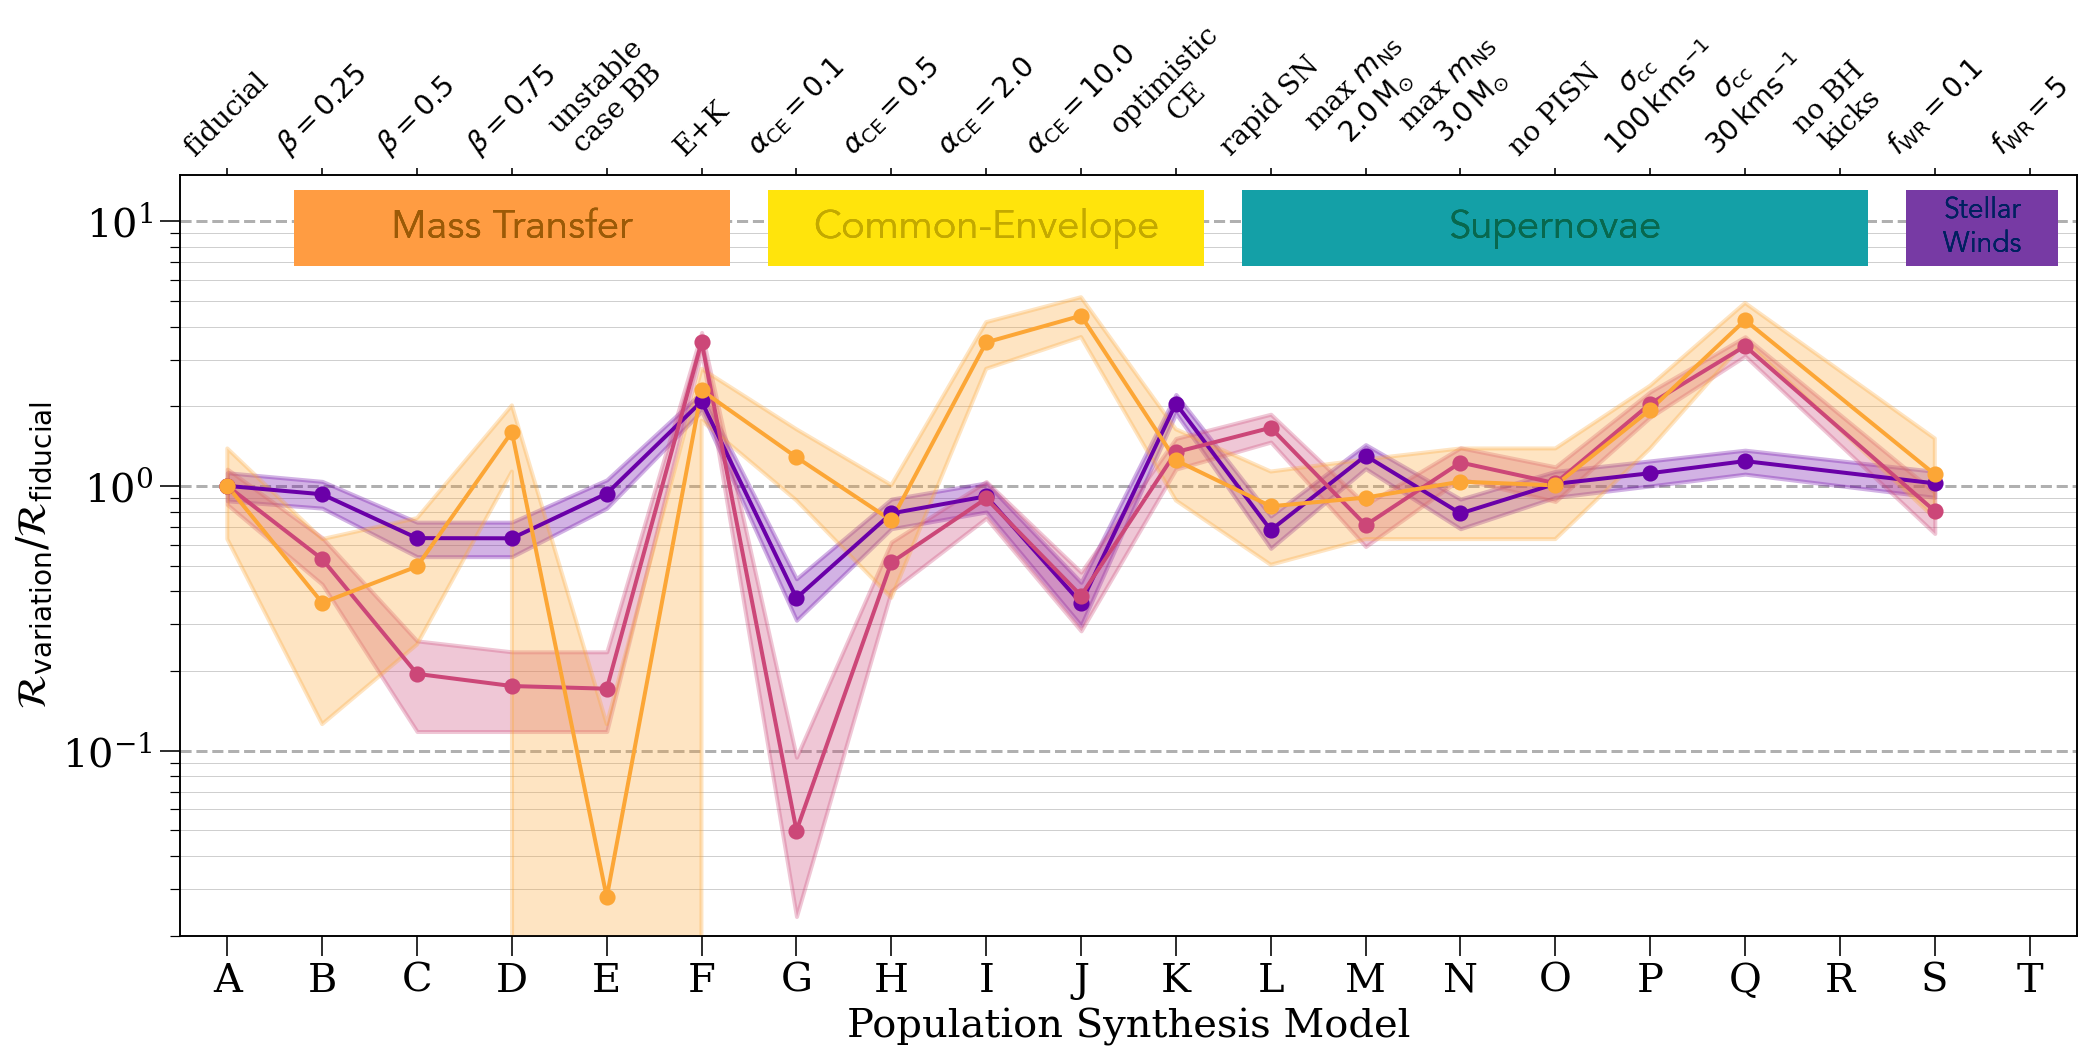

In [37]:
fig, ax = plt.subplots(1, figsize=(17, 7))
fig.subplots_adjust(hspace=0.15)

for dco_type in dco_types:
    plot_relative_variations(dco_type, variations, detections_4yr,
                             fig=fig, ax=ax, show=False, yscale="log", limit=(2e-2, 1.5e1))
    
top_ax = ax.twiny()
top_ax.set_xticks(ax.get_xticks())
top_ax.set_xlim(ax.get_xlim())
top_ax.set_xticklabels([variations[v]["med"] for v in range(len(variations))], rotation=45, fontsize=0.7*fs)

ax.set_xlabel("Population Synthesis Model", fontsize=fs)

plt.savefig("../figures/fig14_dco_relative_rates.pdf", format="pdf", bbox_inches="tight")
    
plt.show()

# Detection rate table

In [48]:
for i in range(len(variations)):
    table_line = variations[i]["short"] + " & " + variations[i]["long"]
    for detection in [detections_4yr, detections_10yr]:
        for j in range(len(detection)):
            mean = np.mean(detection[j][i])
            low, high = scipy.stats.poisson(mean).ppf(0.5 - (0.6827 / 2)),\
                scipy.stats.poisson(mean).ppf(0.5 + (0.6827 / 2)),
            
            lower = mean - low
            upper = high - mean
            table_line += r" & \confinv{" + "{:.1f}".format(mean) + "}{" \
                        + "{:.1f}".format(lower) + "}{" \
                        + "{:.1f}".format(upper) + "}"
    table_line += "\\\\"
    print(table_line)

A & Fiducial & \confinv{74.0}{9.0}{9.0} & \confinv{42.4}{6.4}{6.6} & \confinv{7.9}{2.9}{3.1} & \confinv{117.9}{10.9}{11.1} & \confinv{71.3}{8.3}{8.7} & \confinv{13.0}{4.0}{4.0}\\
B & Fixed mass transfer efficiency of $\beta=0.25$ & \confinv{68.8}{7.8}{8.2} & \confinv{22.4}{4.4}{4.6} & \confinv{2.9}{1.9}{2.1} & \confinv{107.8}{10.8}{10.2} & \confinv{36.9}{5.9}{6.1} & \confinv{4.6}{1.6}{2.4}\\
C & Fixed mass transfer efficiency of $\beta=0.5$ & \confinv{47.0}{7.0}{7.0} & \confinv{8.3}{3.3}{2.7} & \confinv{3.9}{1.9}{2.1} & \confinv{75.8}{8.8}{9.2} & \confinv{13.6}{3.6}{3.4} & \confinv{6.4}{2.4}{2.6}\\
D & Fixed mass transfer efficiency of $\beta=0.75$ & \confinv{46.9}{6.9}{7.1} & \confinv{7.4}{2.4}{2.6} & \confinv{12.7}{3.7}{3.3} & \confinv{71.2}{8.2}{8.8} & \confinv{12.1}{3.1}{3.9} & \confinv{21.1}{4.1}{4.9}\\
E & Case BB mass transfer is always unstable & \confinv{69.3}{8.3}{8.7} & \confinv{7.3}{2.3}{2.7} & \confinv{0.2}{0.2}{0.8} & \confinv{109.3}{10.3}{10.7} & \confinv{11.8}{3.8}{3.2}